## Classification of Pistachio Nuts using CNN with Keras

### Introduction
Pistachios are a significant crop with considerable economic value, and their classification is essential for effective post-harvest processing. This project aims to develop a Convolutional Neural Network (CNN) model using Keras to classify two distinct classes of pistachio nuts: Kirmizi and Siirt.

### Background
Pistachio nuts have various species that cater to different market demands, making accurate classification crucial for quality control and market segmentation. Traditional methods of classification can be time-consuming and may not achieve the desired accuracy. Therefore, leveraging advanced machine learning techniques, specifically CNNs, presents an innovative solution to enhance classification efficiency.

### Objective
In this notebook, we will:

Load and preprocess a dataset containing images of Kirmizi and Siirt pistachios.
Build a CNN model using Keras to automate the classification process.
Evaluate the model’s performance in distinguishing between the two classes.

### Why CNN?
Convolutional Neural Networks (CNNs) are particularly effective for image classification tasks due to their ability to automatically extract features from images. This capability enables them to learn complex patterns, making them a powerful tool for our classification problem.

### Dataset
We will be using a dataset comprising images of Kirmizi and Siirt pistachios. Each class will be represented by a diverse set of images to ensure the model learns effectively.
Link: [Pistachio Image Dataset](https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset)


### CNN Architecture
We will start with a simple CNN architecture that consists of convolutional layers followed by max-pooling layers. This architecture is commonly used for image classification tasks and can be further optimized based on the model's performance.

### Architecture Overview Drawing

## Steps
1. Load and preprocess the dataset.
2. Build a CNN model using Keras.
3. Compile and train the model in CPU.
4. Evaluate the model's performance.
5. Craete Docker image to run in locally with gpu enabled
6. Compile and train the model in GPU.
7. Evaluate the model's performance in GPU.


In [17]:
#conda activate llm-res

#!pip3 freeze > requirements.txt

# !pip3 install tensorflow

### Loading and Preprocessing the Data

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
data_dir = './data/Pistachio_Image_Dataset/Pistachio_Image_Dataset/'
class_names = ['Kirmizi_Pistachio', 'Siirt_Pistachio']
print(class_names)

# Load the file names

dataset_files_names = []

for c in class_names:
    # list files using os library
    for filename in os.listdir(data_dir+c):
        file_path = os.path.join(data_dir+c, filename)
        
        # Check if the path is a file
        if os.path.isfile(file_path):
    
            # create the list of data points with class and file name
            dataset_files_names.append({
                'label': c,
                'file_name': file_path
            })

# Create a DataFrame
df = pd.DataFrame(dataset_files_names)

# print each class count
print(df['label'].value_counts())

['Kirmizi_Pistachio', 'Siirt_Pistachio']
label
Kirmizi_Pistachio    1232
Siirt_Pistachio       916
Name: count, dtype: int64


In [20]:
# train, dev, test split
from sklearn.model_selection import train_test_split
random_state=42
# Split the data into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)

# shuffle the df_train data with random state
df_train = df_train.sample(frac=1, random_state=random_state).reset_index(drop=True)


# Split the data into train and dev
df_test, df_dev = train_test_split(df_test, test_size=0.5, random_state=random_state)


### Dta distribution

In [21]:
print('Train:', df_train.shape[0])
print('Dev:', df_dev.shape[0])
print('Test:', df_test.shape[0])

print("Train:",df_train['label'].value_counts())
print("Dev:",df_dev['label'].value_counts())
print("Test:",df_test['label'].value_counts())

Train: 1718
Dev: 215
Test: 215
Train: label
Kirmizi_Pistachio    988
Siirt_Pistachio      730
Name: count, dtype: int64
Dev: label
Kirmizi_Pistachio    136
Siirt_Pistachio       79
Name: count, dtype: int64
Test: label
Kirmizi_Pistachio    108
Siirt_Pistachio      107
Name: count, dtype: int64


### View some data

In [22]:
import tensorflow as tf
import keras 

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

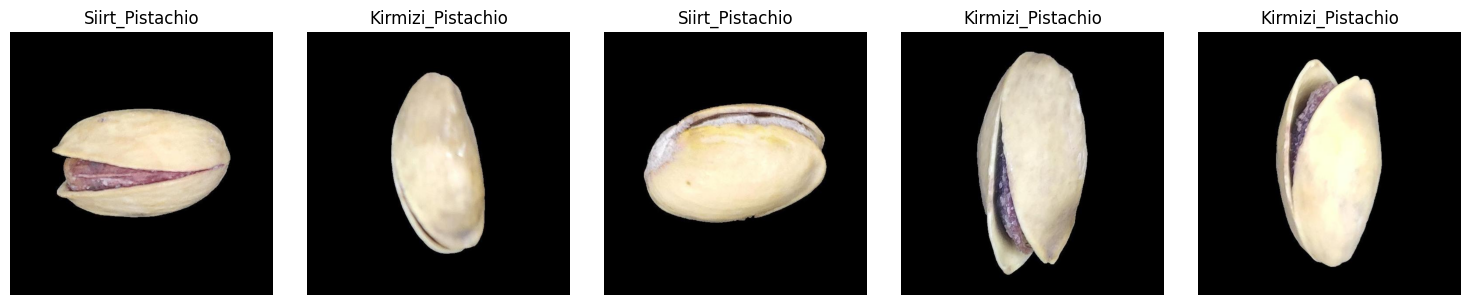

In [23]:
# load image using pil

def load_image(file_path,size=None):
    # Load image without resizing
    img = image.load_img(file_path)

    # Get the original dimensions of the image
    original_size = img.size  # (width, height)

    # Resize the image
    if size is not None:
        img = img.resize(size)

    # Convert image to numpy array
    img_array = image.img_to_array(img)
    return img_array, original_size


# Plotting 5 images in a row
plt.figure(figsize=(15, 3))  # Set the figure size (15x3 inches)

items =df_train.sample(5, random_state=55)
for i in range(5):
    plt.subplot(1, 5, i+1)  # 1 row, 5 columns, and plot index i+1
    dpoint = items.iloc[i]
    img, original_size = load_image(dpoint['file_name'])
    shape = img.shape

    # convert to uint8
    img = img.astype(np.uint8)  
    
    plt.imshow(img)  # Show the image (assuming grayscale)
    plt.title(dpoint['label'])  # Set the class label as the title
    plt.axis('off')  # Hide the axis

# Display the images
plt.tight_layout()  # Adjust the spacing between the plots
plt.show()

### Data Augmentation and Batch Generation

In [24]:
# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_datagen(rescale=1./255):
    # Create an ImageDataGenerator object
    datagen = ImageDataGenerator(
        rescale=rescale, # normalize the pixel values
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    return datagen

# Load an image
def batch_generator(data, batch_size, datagen, shuffle=True,input_dim_size=244):
    # Get the number of samples in the dataset
    n = data.shape[0]
    
    # Get the number of batches
    n_batches = n // batch_size
    
    # Generate batches
    while True:
        if shuffle:
            data = data.sample(frac=1).reset_index(drop=True)
        
        for i in range(n_batches):
            # Get the batch data
            batch_data = data.iloc[i*batch_size:(i+1)*batch_size]
            
            # Initialize the array for storing the images
            X_batch = np.empty((batch_size, input_dim_size, input_dim_size, 3))
            y_batch = np.empty((batch_size), dtype=int)
            
            # Load the images
            for j, (index, item) in enumerate(batch_data.iterrows()):
                img, _ = load_image(item['file_name'], size=(input_dim_size, input_dim_size))
                X_batch[j] = img

                y_batch[j] = class_names.index(item['label'])
                # print(y_batch[j])
            
            # Apply data augmentation
            X_batch = next(datagen.flow(X_batch, shuffle=False, batch_size=batch_size))
            
            yield X_batch, y_batch

### Show augmented images

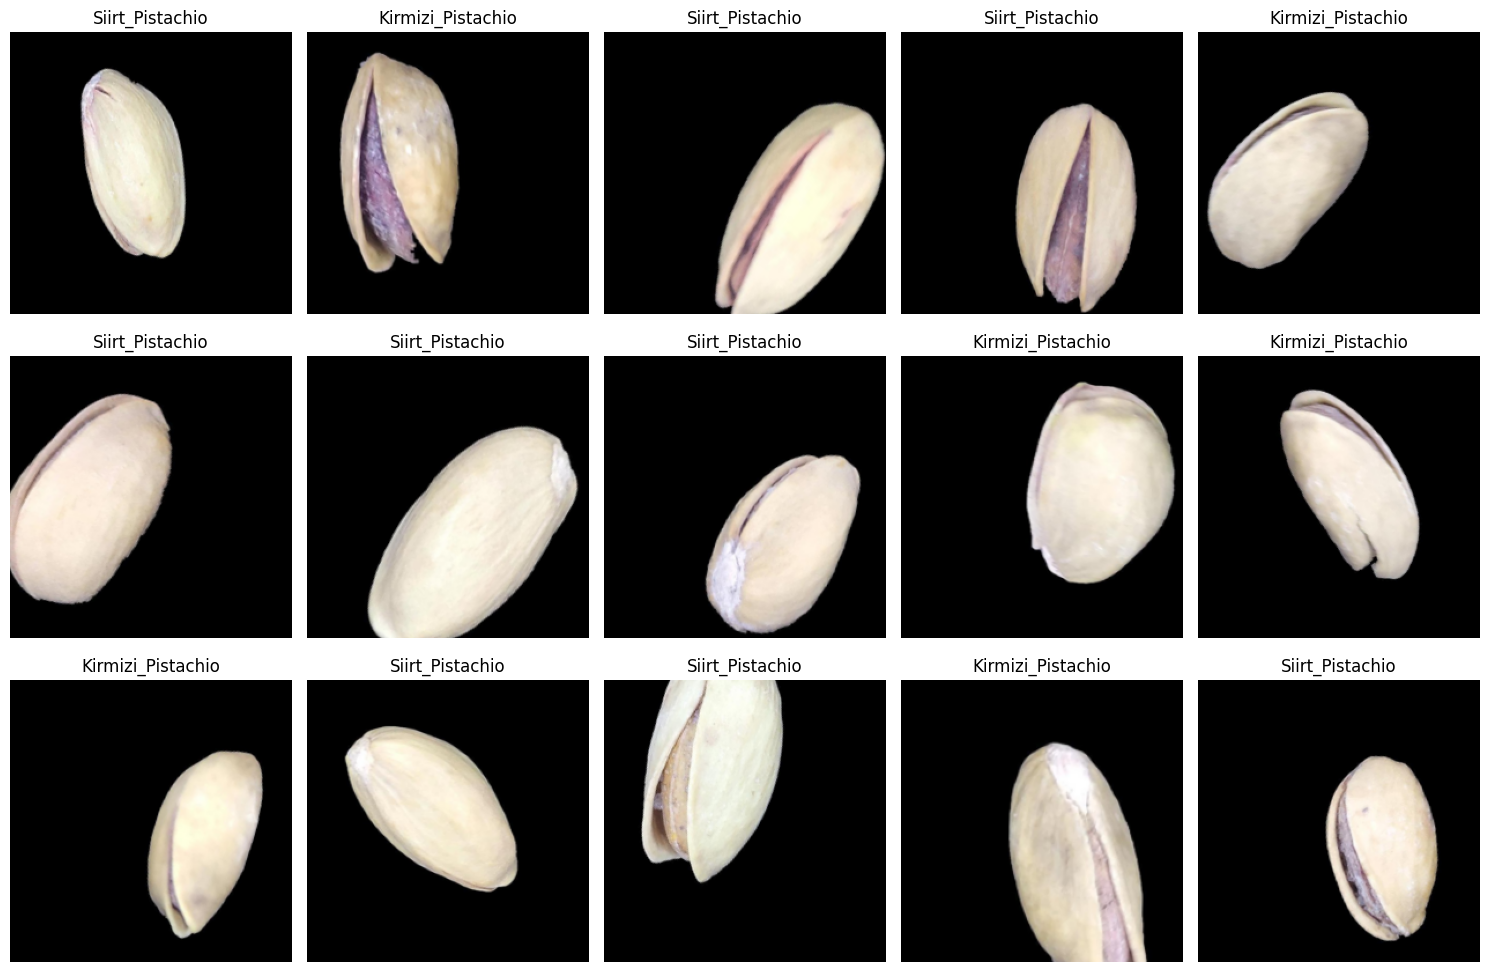

In [25]:
# using that batchgen  function  generate one batch of data and plot it 
batch_size = 15
gen = batch_generator(df_train, batch_size, create_datagen(1))

# Plotting augmented images
X_batch, Y_batch = next(gen)

plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    img = X_batch[i].astype(np.uint8)
    plt.imshow(img)
    plt.title(class_names[int(Y_batch[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()


### Binary Classification Model

We have only two classee Kirmizi and Siirt. So we will use binary classification model.

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape):
    # Define the model using the Keras Functional API
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (5, 5), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)  # Dropout layer

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # x = layers.Dropout(0.25)(x)  # Dropout layer

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # x = layers.Dropout(0.25)(x)  # Dropout layer

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)  # Dropout layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model


In [27]:
batch_size = 64
num_classes = len(class_names)  # Number of classes
input_shape = (224, 224, 3)

# Create the data generator with pixel normalization
datagen = create_datagen(1./255)

# Create the batch generator
gen = batch_generator(df_train, batch_size, datagen,False,input_dim_size=input_shape[0])
val_gen = batch_generator(df_dev, batch_size, datagen,False,input_dim_size=input_shape[0])

# Create the model
model = create_cnn_model(input_shape)

# print summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,265 (42.61 MB)

 Trainable params: 11,170,945 (42.61 MB)

 Non-trainable params: 320 (1.25 KB)

In [28]:

# Compile the model
# adam optimizer use for optimization
# adam optmizer also use default as mini batch gradient descent
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the generator and capture the history
steps_per_epoch = len(df_train) // batch_size
validation_steps = len(df_dev) // batch_size

history = model.fit(gen, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=10,
                    validation_data=val_gen,
                    validation_steps=validation_steps,                    
                    )

Epoch 1/10
 2/26 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - accuracy: 0.5000 - loss: 0.9523

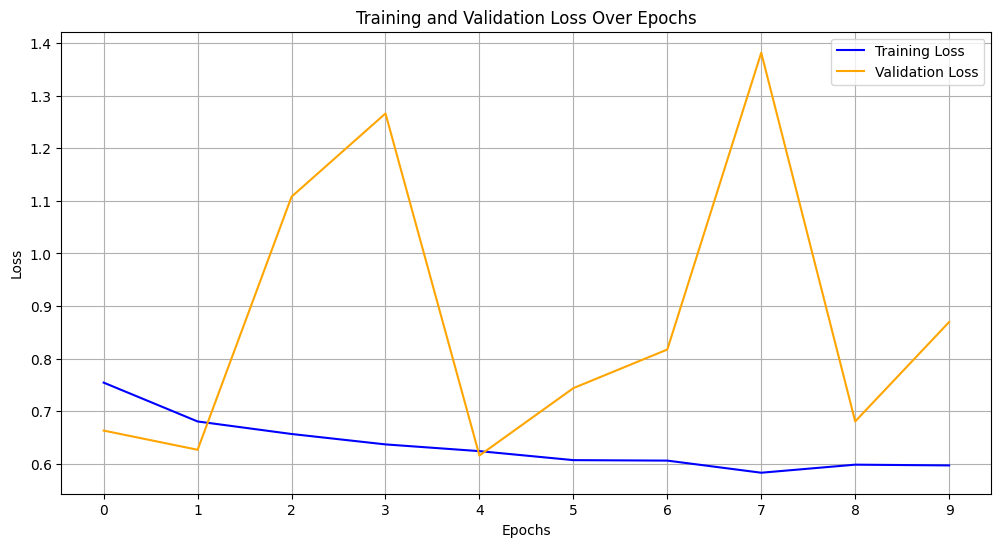

In [13]:
# Extract loss values
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(len(train_loss_values)))  # Set x-ticks to match epochs
plt.legend()
plt.grid(True)
plt.show()

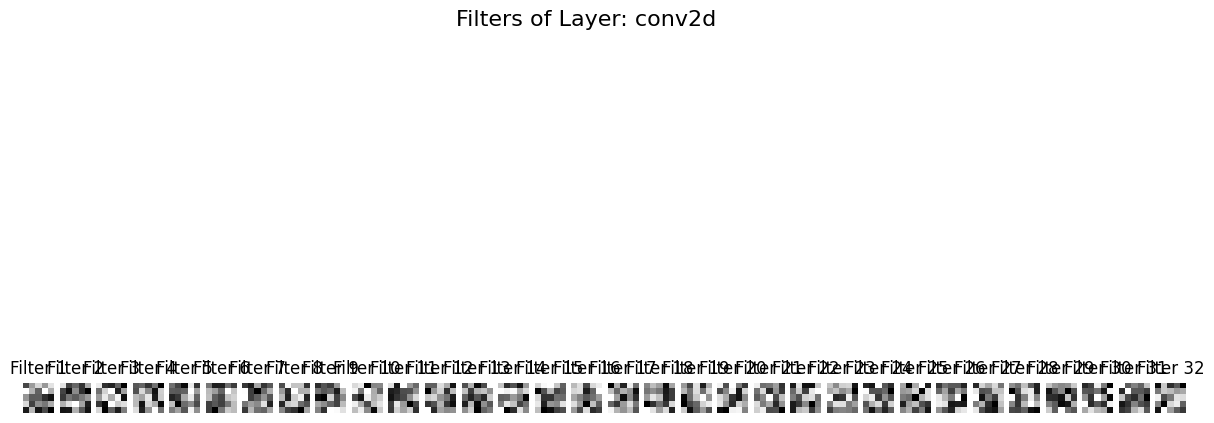

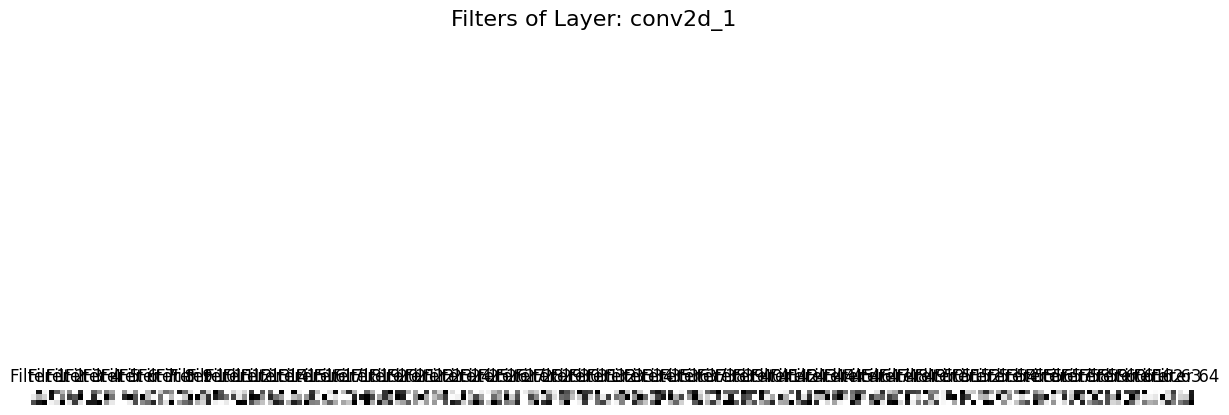

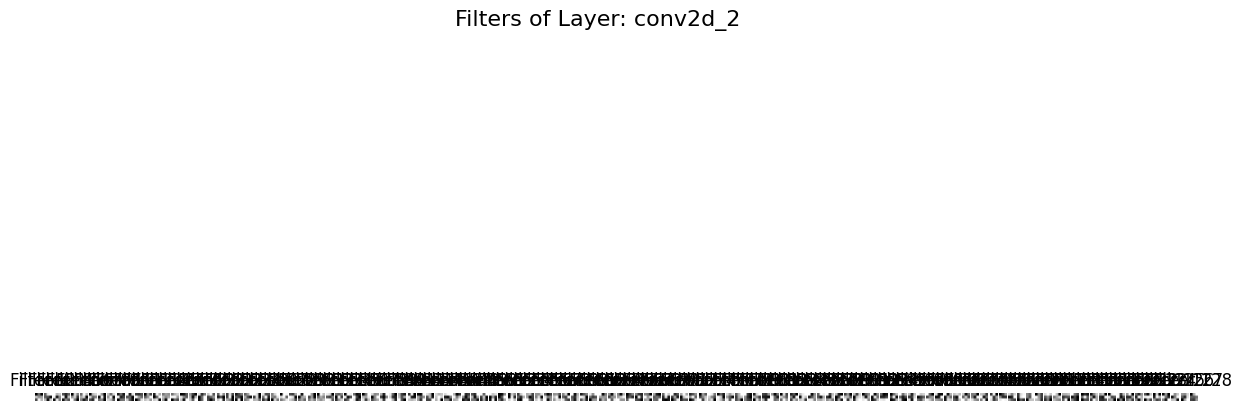

In [14]:
def plot_filters(model):
    # Iterate over the layers in the model
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D):
            filters, biases = layer.get_weights()  # Get the filters and biases
            n_filters = filters.shape[3]  # Number of filters in the layer
            filter_size = filters.shape[0]  # Size of each filter (assuming square filters)
            
            # Plot each filter
            plt.figure(figsize=(15, 8))
            for i in range(n_filters):
                plt.subplot(1, n_filters, i + 1)
                # Get the filter for the current index
                filter_img = filters[:, :, :, i]
                # Normalize filter values to [0, 1] for better visualization
                filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())
                
                # Plot the filter
                plt.imshow(filter_img[:, :, 0], cmap='gray')  # Assuming the filter has 1 channel
                plt.axis('off')
                plt.title(f'Filter {i+1}')
            plt.suptitle(f'Filters of Layer: {layer.name}', fontsize=16)
            plt.show()
plot_filters(model)

### Save model


In [15]:
model.save('my_model.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


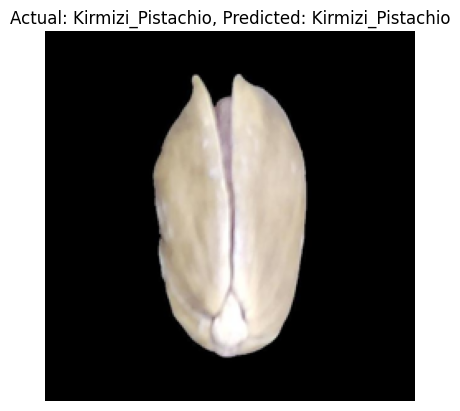

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


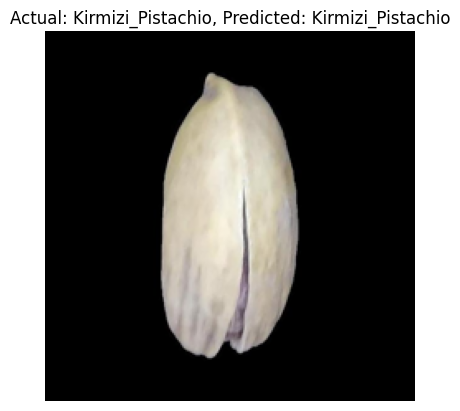

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


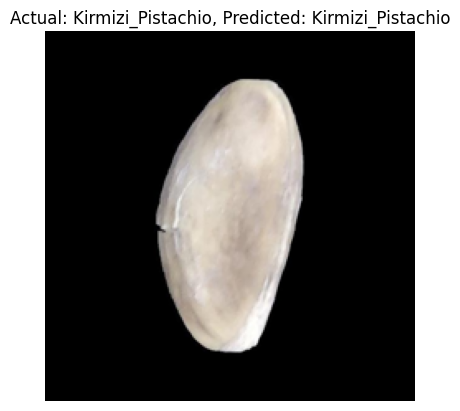

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


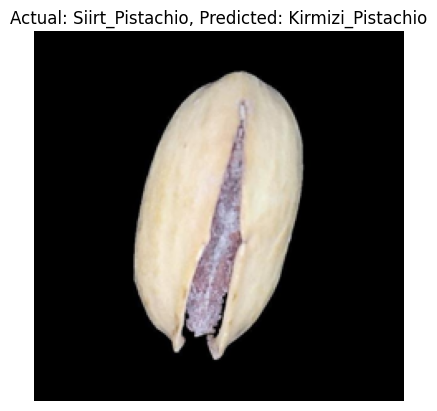

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


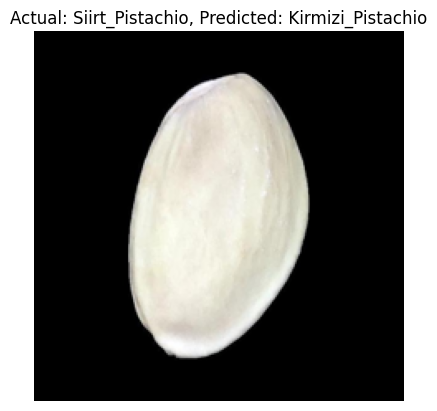

In [16]:
# predict the test data

items = df_test.sample(5, random_state=55)

for i in range(5):
    dpoint = items.iloc[i]
    img, _ = load_image(dpoint['file_name'], size=(input_shape[0], input_shape[1]))
    img = img.astype(np.uint8)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    pred = model.predict(img)
    pred_class = class_names[np.argmax(pred)]
    plt.imshow(img[0])
    plt.title(f'Actual: {dpoint["label"]}, Predicted: {pred_class}')
    plt.axis('off')
    plt.show()